<a href="https://colab.research.google.com/github/SimoneRosset/AUGMENTATION_GAN/blob/master/AUGMENTATION_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## AUGMENTATION_GAN
based on this [paper](https://arxiv.org/pdf/1803.01229.pdf)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [4]:
img_dim=64
transform = transforms.Compose(
    [transforms.RandomRotation(45),
     transforms.RandomHorizontalFlip(p=0.5),
     #transforms.RandomVerticalFlip(p=0.5),
     transforms.Resize(size=img_dim,interpolation=2),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ("airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck")

Files already downloaded and verified
Files already downloaded and verified


In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


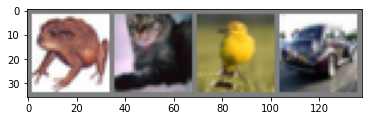

 frog   cat  bird   car


In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):

    def _name(self):
        return "CNN"

    def _conv2d(self, in_channels, out_channels):
        return nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1
        )

    def _build_models(self):
        self.conv1 = nn.Sequential(
            self._conv2d(self.channels_size, self.hidden_size),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            self._conv2d(self.hidden_size , self.hidden_size * 2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 2),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            self._conv2d(self.hidden_size*2, self.hidden_size * 4),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(self.hidden_size * 4),
            nn.MaxPool2d(2, 2)
        )
        self.dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.hidden_size * 4 * 4 * 4, 256),
            nn.ReLU(),
            #nn.Dropout(p=0.5),
            nn.Linear(256, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
            #nn.Softmax(dim=1),
        )
        return self.conv1, self.conv2, self.conv3, self.dense

    def __init__(self, hidden_size, channels_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.channels_size= channels_size
        self._models = self._build_models()
        self.name = self._name()

    def forward(self, image):
        x = self._models[0](image)
        x_1 = self._models[1](x)
        x_2 = self._models[2](x_1)
        x_3 = self._models[3](x_2)
        return x_3

In [44]:
hidden_size=32
channels_size=3

net=CNN(hidden_size, channels_size)

In [45]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [46]:
epochs=150

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense): Sequential(
    (0): Flatten()
    (1): Linear(in_features=2048, out_featu

In [47]:
for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
        
    # print('[%d] loss: %.3f' %
    #               (epoch + 1, running_loss / i))
    # running_loss = 0.0

print('Finished Training')
PATH = './stl10_net.pth'
torch.save(net.state_dict(), PATH)

[1,  2000] loss: 1.665
[1,  4000] loss: 1.363
[1,  6000] loss: 1.228
[1,  8000] loss: 1.120
[1, 10000] loss: 1.040
[1, 12000] loss: 1.013
[2,  2000] loss: 0.901
[2,  4000] loss: 0.863
[2,  6000] loss: 0.862
[2,  8000] loss: 0.835
[2, 10000] loss: 0.817
[2, 12000] loss: 0.802
[3,  2000] loss: 0.651
[3,  4000] loss: 0.680
[3,  6000] loss: 0.679
[3,  8000] loss: 0.666
[3, 10000] loss: 0.682
[3, 12000] loss: 0.675
[4,  2000] loss: 0.525
[4,  4000] loss: 0.545
[4,  6000] loss: 0.556
[4,  8000] loss: 0.570
[4, 10000] loss: 0.550
[4, 12000] loss: 0.567
[5,  2000] loss: 0.416
[5,  4000] loss: 0.421
[5,  6000] loss: 0.435
[5,  8000] loss: 0.465
[5, 10000] loss: 0.474
[5, 12000] loss: 0.479
[6,  2000] loss: 0.319
[6,  4000] loss: 0.344
[6,  6000] loss: 0.348
[6,  8000] loss: 0.375
[6, 10000] loss: 0.399
[6, 12000] loss: 0.405
[7,  2000] loss: 0.253
[7,  4000] loss: 0.269
[7,  6000] loss: 0.284
[7,  8000] loss: 0.310
[7, 10000] loss: 0.323
[7, 12000] loss: 0.321
[8,  2000] loss: 0.201
[8,  4000] 

KeyboardInterrupt: ignored

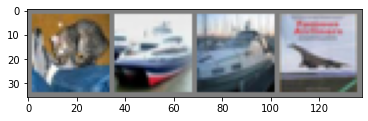

GroundTruth:    cat  ship  ship plane


In [52]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [53]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship truck plane


In [54]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 77 %


In [55]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 81 %
Accuracy of   car : 88 %
Accuracy of  bird : 69 %
Accuracy of   cat : 61 %
Accuracy of  deer : 73 %
Accuracy of   dog : 69 %
Accuracy of  frog : 80 %
Accuracy of horse : 77 %
Accuracy of  ship : 86 %
Accuracy of truck : 82 %
